# Tweets

For first run in jupyter run next comand:
!pip install pandas nltk sklearn matplotlib gensim

In [1]:
!python3 -m pip install pandas nltk sklearn matplotlib gensim pyLDAvis

!which python3
!python --version

You should consider upgrading via the '/Users/marina.romashkova/.pyenv/versions/3.9.5/bin/python3 -m pip install --upgrade pip' command.
/Users/marina.romashkova/.pyenv/versions/3.9.5/bin/python3
Python 3.9.5


In [2]:
import json
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('stopwords')

from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from gensim.models import word2vec


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data preparation

### Make dataframe


In [3]:
df_neg = pd.read_csv("./data/processedNegative.csv", header=None, sep=",")
df_neg = df_neg.T.rename(columns={0:'tweet'})
df_neg['tone'] = "negative"

In [4]:
df_neg.head()

,tweet,tone
0,How unhappy some dogs like it though,negative
1,talking to my over driver about where I'm goin...,negative
2,Does anybody know if the Rand's likely to fall...,negative
3,I miss going to gigs in Liverpool unhappy,negative
4,There isnt a new Riverdale tonight ? unhappy,negative


In [5]:
df_pos = pd.read_csv("./data/processedPositive.csv", header=None, sep=",")
df_pos = df_pos.T.rename(columns={0:'tweet'})
df_pos['tone'] = "positive"

In [6]:
df_pos.head()

,tweet,tone
0,An inspiration in all aspects: Fashion,positive
1,fitness,positive
2,beauty and personality. :)KISSES TheFashionIcon,positive
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,positive
4,Beautiful album from the greatest unsung guit...,positive


In [7]:
df_neut = pd.read_csv("./data/processedNeutral.csv", header=None)
df_neut = df_neut.T.rename(columns={0:'tweet'})
df_neut['tone'] = "neutral"

In [8]:
df_neut.head()

,tweet,tone
0,Pak PM survives removal scare,neutral
1,but court orders further probe into corruptio...,neutral
2,Supreme Court quashes criminal complaint again...,neutral
3,Art of Living's fights back over Yamuna floodp...,neutral
4,livid.,neutral


In [9]:
df = pd.concat([df_neg, df_pos, df_neut], ignore_index=True)

In [10]:
df

,tweet,tone
0,How unhappy some dogs like it though,negative
1,talking to my over driver about where I'm goin...,negative
2,Does anybody know if the Rand's likely to fall...,negative
3,I miss going to gigs in Liverpool unhappy,negative
4,There isnt a new Riverdale tonight ? unhappy,negative
...,...,...
3868,IDFC official Vikram Limaye,neutral
3869,former captain Diana Edulji are others in pan...,neutral
3870,Supreme Court names former CAG as head of 4-me...,neutral
3871,Court summons CM suspended BJP MP as accused i...,neutral


<AxesSubplot:>

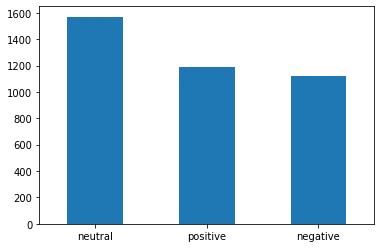

In [11]:
df['tone'].value_counts().plot(kind="bar", rot=0)

## Preprocessing

tokenization - split tweets into words

In [12]:
df['tokenization'] = df.apply(lambda row: nltk.word_tokenize(str(row['tweet']).lower()), axis=1)

In [13]:
df

,tweet,tone,tokenization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u..."
...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a..."



stemming - finding the stem of a word

In [14]:
stemmer = nltk.stem.SnowballStemmer(language="english")
df['stemming'] = df['tokenization'].apply(lambda x: [stemmer.stem(y) for y in x])
df

,tweet,tone,tokenization,stemming
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un..."
...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu..."


In [15]:
stemmer_ = nltk.stem.PorterStemmer()
df['stemming+'] = df['tokenization'].apply(lambda x: [stemmer_.stem(y) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un..."
...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu..."



lemmatization - finding the root of a word

In [16]:
lemmatizer = nltk.stem.WordNetLemmatizer()
df['lemmatization'] = df['tokenization'].apply(lambda x: [lemmatizer.lemmatize(str(y)) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u..."
...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac..."


misspealing - correct possible misspealings

In [17]:
correct_words = words.words()

def misspealings(word):
  temp = [(jaccard_distance(set(ngrams(word, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==word[0]]
  return sorted(temp, key = lambda val:val[0])[0][1]

sample_word = "amzing"
print(f'The word "{sample_word}" is a misspealing of word - "{misspealings(sample_word)}"')

The word "amzing" is a misspealing of word - "amazing"


In [18]:
def check_misspeal(word):
    if len(word) > 2 and "'" not in word and "." not in word and word.isalpha():
        return misspealings(word)
    return word
    

In [19]:
df['misspealings'] = df['tokenization'].apply(lambda x: [check_misspeal(str(y)) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[there, is, a, new, riverdamp, tonight, ?, unh..."
...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, dian, educe, are, other, in,..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, name, former, cag, as, head, ..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[court, summons, cm, suspended, bobjerom, mp, ..."


In [20]:
df['misspealings+lemma'] = df['lemmatization'].apply(lambda x: [check_misspeal(str(y)) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[there, is, a, new, riverdamp, tonight, ?, unh...","[there, is, a, new, riverdamp, tonight, ?, unh..."
...,...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]","[id, official, viagram, liman]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, dian, educe, are, other, in,...","[former, captain, dian, educe, are, other, in,..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, name, former, cag, as, head, ...","[supreme, court, name, former, cag, a, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[court, summons, cm, suspended, bobjerom, mp, ...","[court, summons, cm, suspended, bobjerom, mp, ..."


Filtering tweets

In [21]:
stop_words = set(stopwords.words('english'))
example_sent = """This is a sample sentence,
                  showing off the stop words filtration"""
word_tokens = word_tokenize(example_sent)
 
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

print(f'The sentence "{example_sent}" was filtered:\n "{filtered_sentence}"')

The sentence "This is a sample sentence,
                  showing off the stop words filtration" was filtered:
 "['sample', 'sentence', ',', 'showing', 'stop', 'words', 'filtration']"


In [22]:
df['filtered+tokenization'] = df['tokenization'].apply(lambda x: [y for y in x if not y.lower() in stop_words])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[there, is, a, new, riverdamp, tonight, ?, unh...","[there, is, a, new, riverdamp, tonight, ?, unh...","[isnt, new, riverdale, tonight, ?, unhappy]"
...,...,...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]","[id, official, viagram, liman]","[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, dian, educe, are, other, in,...","[former, captain, dian, educe, are, other, in,...","[former, captain, diana, edulji, others, panel..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, name, former, cag, as, head, ...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, names, former, cag, head, 4-m..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[court, summons, cm, suspended, bobjerom, mp, ...","[court, summons, cm, suspended, bobjerom, mp, ...","[court, summons, cm, suspended, bjp, mp, accus..."


In [23]:
df['misspealings+lemma+filtered'] = df['misspealings+lemma'].apply(lambda x: [y for y in x if not y.lower() in stop_words])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[there, is, a, new, riverdamp, tonight, ?, unh...","[there, is, a, new, riverdamp, tonight, ?, unh...","[isnt, new, riverdale, tonight, ?, unhappy]","[new, riverdamp, tonight, ?, unhappy]"
...,...,...,...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]","[id, official, viagram, liman]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, dian, educe, are, other, in,...","[former, captain, dian, educe, are, other, in,...","[former, captain, diana, edulji, others, panel...","[former, captain, dian, educe, panel, run]"
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, name, former, cag, as, head, ...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, names, former, cag, head, 4-m...","[supreme, court, name, former, cag, head, 4-me..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[court, summons, cm, suspended, bobjerom, mp, ...","[court

## Encoding

### OneHotEncoder


In [24]:
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform((df[['tweet']]).astype('str'))
df['ohe_tweet'] = list(X_ohe)
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered,ohe_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[there, is, a, new, riverdamp, tonight, ?, unh...","[there, is, a, new, riverdamp, tonight, ?, unh...","[isnt, new, riverdale, tonight, ?, unhappy]","[new, riverdamp, tonight, ?, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]","[id, official, viagram, liman]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, dian, educe, are, other, in,...","[former, captain, dian, educe, are, other, in,...","[former, captain, diana, edulji, others, panel...","[former, captain, dian, educe, panel, run]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, name, former, cag, as, head, ...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, names, former, cag, head, 4-m...","[su

In [25]:
preprocessing_ways = [
    "tokenization",
    "stemming",
    "stemming+",
    "lemmatization",
    "misspealings",
    "misspealings+lemma",
    "filtered+tokenization",
    "misspealings+lemma+filtered"
]

In [26]:
for way in preprocessing_ways:
    X_ohe = ohe.fit_transform((df[[way]]).astype('str'))
    df['ohe_' + way] = list(X_ohe)
df    

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,There isnt a new Riverdale tonight ? unhapp

### WordCounts
Convert a collection of text documents to a matrix of token counts.

In [27]:
vectorizer_wc = CountVectorizer(ngram_range=(1, 3))
X_wc = vectorizer_wc.fit_transform((df['tweet']).astype('str'))
df['wc_tweet'] = list(X_wc.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered,wc_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [28]:
for way in preprocessing_ways:
    X_wc = vectorizer_wc.fit_transform((df[way]).astype('str'))
    df['wc_' + way] = list(X_wc.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered,...,ohe_misspealings+lemma+filtered,wc_tweet,wc_tokenization,wc_stemming,wc_stemming+,wc_lemmatization,wc_misspealings,wc_misspealings+lemma,wc_filtered+tokenization,wc_misspealings+lemma+filtered
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[

### TFIDF

In [29]:
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform((df['tweet']).astype('str'))
df['tfidf_tweet'] = list(X_tfidf.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered,...,wc_tweet,wc_tokenization,wc_stemming,wc_stemming+,wc_lemmatization,wc_misspealings,wc_misspealings+lemma,wc_filtered+tokenization,wc_misspealings+lemma+filtered,tfidf_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0,

In [30]:
for way in preprocessing_ways:
    X_tfidf = vectorizer_tfidf.fit_transform((df[way]).astype('str'))
    df['tfidf_' + way] = list(X_tfidf.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered,...,wc_misspealings+lemma+filtered,tfidf_tweet,tfidf_tokenization,tfidf_stemming,tfidf_stemming+,tfidf_lemmatization,tfidf_misspealings,tfidf_misspealings+lemma,tfidf_filtered+tokenization,tfidf_misspealings+lemma+filtered
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, 'm, going, said, 'd, love, g...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, if, the, rand, 's, likel...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, 's, likely, fall, d...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[i, miss, going, to, gig, in, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0

### Word2Vec

In [31]:
vectorizer_w2v = word2vec.Word2Vec(df['tokenization'], min_count=1, vector_size = 100, window = 5)

In [32]:
vectorizer_w2v.wv.most_similar('happy', 10)

[('connect', 0.9615136981010437),
 ('recent', 0.804908037185669),
 ('thursday', 0.7111150622367859),
 ('follow', 0.45943012833595276),
 ('trick', 0.44421571493148804),
 ('commando', 0.32795336842536926),
 ('great', 0.3107462227344513),
 ('smooth', 0.3075921833515167),
 ('ought', 0.29486629366874695),
 ('thanks', 0.29220837354660034)]

In [33]:
vectorizer_w2v.wv.most_similar('positive', 10)

[('comfortable', 0.3027094006538391),
 ('veggies', 0.3018379509449005),
 ('beginning', 0.2949639558792114),
 ('survey', 0.2780837416648865),
 ('bae', 0.2667633891105652),
 ('charlie', 0.24233095347881317),
 ('tabled', 0.24142755568027496),
 ('explode', 0.23658089339733124),
 ('shoutout', 0.23338963091373444),
 ('clauditte', 0.22291675209999084)]

In [34]:
vectorizer_w2v.wv.most_similar('unhappy', 10)

[('adblocker', 0.30785346031188965),
 ('insight', 0.3030245304107666),
 ('amanda', 0.3008870780467987),
 ('annette', 0.2957611680030823),
 ('lab', 0.27527397871017456),
 ('sunnyside', 0.24441593885421753),
 ('stealing', 0.24241776764392853),
 ('157', 0.24111859500408173),
 ('sketches', 0.2361643761396408),
 ('ios', 0.2355777621269226)]

## Similarity

The top-10 most similar tweets for all the 18 ways of preprocessing

In [35]:
vector_columns = [column for column in df.columns if column.startswith(("ohe", "wc", "tfidf"))]
vector_columns

['ohe_tweet',
 'ohe_tokenization',
 'ohe_stemming',
 'ohe_stemming+',
 'ohe_lemmatization',
 'ohe_misspealings',
 'ohe_misspealings+lemma',
 'ohe_filtered+tokenization',
 'ohe_misspealings+lemma+filtered',
 'wc_tweet',
 'wc_tokenization',
 'wc_stemming',
 'wc_stemming+',
 'wc_lemmatization',
 'wc_misspealings',
 'wc_misspealings+lemma',
 'wc_filtered+tokenization',
 'wc_misspealings+lemma+filtered',
 'tfidf_tweet',
 'tfidf_tokenization',
 'tfidf_stemming',
 'tfidf_stemming+',
 'tfidf_lemmatization',
 'tfidf_misspealings',
 'tfidf_misspealings+lemma',
 'tfidf_filtered+tokenization',
 'tfidf_misspealings+lemma+filtered']

In [68]:
def top_similar(array_coisine, n=10):
    c = 0
    list_indexes = []
    index_repeate = []
    limit = 0.9999999999999
    while c < n:
        ind = np.unravel_index(np.argmax(array_coisine, axis=None), array_coisine.shape)
        ind1, ind2 = ind
        if array_coisine[ind1][ind2] < limit and ind1 not in index_repeate and ind2 not in index_repeate and ind1 != ind2:
            value = array_coisine[ind1][ind2]
            list_indexes.append((ind, value))
            index_repeate.extend([ind1, ind2])
            c += 1
        array_coisine[ind1][ind2] = -1
    return list_indexes

In [71]:
list_tweets = df['tweet'].tolist()
def print_similar(text_vectors):
    array = np.array(df[text_vectors].tolist())
    coisine_array = cosine_similarity(array)
    print("coisine_array\n", coisine_array)
    list_indexes = top_similar(coisine_array)
    list_similar = [(list_tweets[ind1], list_tweets[ind2], score) for (ind1, ind2), score in list_indexes]
    df_similar = pd.DataFrame(list_similar, columns =['phrase1', 'phrase2', 'score'])
    print(f'text vector "{text_vectors}":\n{json.dumps(df_similar.to_dict("records"), indent=2)}\n\n')
    

In [72]:
for text_vectors in vector_columns[:1]:
    print_similar(text_vectors)

coisine_array
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
text vector "ohe_tweet":
[
  {
    "phrase1": "How unhappy  some dogs like it though",
    "phrase2": "talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not",
    "score": 0.0
  },
  {
    "phrase1": "Does anybody know if the Rand's likely to fall against the dollar? I got some money  I need to change into R but it keeps getting stronger unhappy ",
    "phrase2": "I miss going to gigs in Liverpool unhappy ",
    "score": 0.0
  },
  {
    "phrase1": "There isnt a new Riverdale tonight ? unhappy ",
    "phrase2": "it's that A*dy guy from pop Asia and then the translator so they'll probs go with them around Aus unhappy ",
    "score": 0.0
  },
  {
    "phrase1": "Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've shamed

In [82]:
for text_vectors in vector_columns[1:26]:
    print_similar(text_vectors)

coisine_array
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
text vector "ohe_tokenization":
[
  {
    "phrase1": "How unhappy  some dogs like it though",
    "phrase2": "talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not",
    "score": 0.0
  },
  {
    "phrase1": "Does anybody know if the Rand's likely to fall against the dollar? I got some money  I need to change into R but it keeps getting stronger unhappy ",
    "phrase2": "I miss going to gigs in Liverpool unhappy ",
    "score": 0.0
  },
  {
    "phrase1": "There isnt a new Riverdale tonight ? unhappy ",
    "phrase2": "it's that A*dy guy from pop Asia and then the translator so they'll probs go with them around Aus unhappy ",
    "score": 0.0
  },
  {
    "phrase1": "Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've

coisine_array
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
text vector "ohe_misspealings":
[
  {
    "phrase1": "How unhappy  some dogs like it though",
    "phrase2": "talking to my over driver about where I'm goinghe said he'd love to go to New York too but since Trump it's probably not",
    "score": 0.0
  },
  {
    "phrase1": "Does anybody know if the Rand's likely to fall against the dollar? I got some money  I need to change into R but it keeps getting stronger unhappy ",
    "phrase2": "I miss going to gigs in Liverpool unhappy ",
    "score": 0.0
  },
  {
    "phrase1": "There isnt a new Riverdale tonight ? unhappy ",
    "phrase2": "it's that A*dy guy from pop Asia and then the translator so they'll probs go with them around Aus unhappy ",
    "score": 0.0
  },
  {
    "phrase1": "Who's that chair you're sitting in? Is this how I find out. Everyone knows now. You've

coisine_array
 [[1.         0.02777778 0.08111071 ... 0.         0.         0.        ]
 [0.02777778 1.         0.10814761 ... 0.05521576 0.         0.01719035]
 [0.08111071 0.10814761 1.         ... 0.03582872 0.         0.        ]
 ...
 [0.         0.05521576 0.03582872 ... 1.         0.05205792 0.        ]
 [0.         0.         0.         ... 0.05205792 1.         0.        ]
 [0.         0.01719035 0.         ... 0.         0.         1.        ]]
text vector "wc_tweet":
[
  {
    "phrase1": "Koalas are dying of thirst  and it's all because of us unhappy  ",
    "phrase2": "are dying of thirst  and it's all because of us unhappy   ",
    "score": 0.9561828874675149
  },
  {
    "phrase1": "Koalas are dying of thirst  and it's all because of us unhappy  ",
    "phrase2": "are dying of thirst  and it's all because of us unhappy   ",
    "score": 0.9561828874675149
  },
  {
    "phrase1": "Hi! We tried to call your number but got no response unhappy  Please share another suitable t

coisine_array
 [[1.         0.02777778 0.10814761 ... 0.         0.         0.        ]
 [0.02777778 1.         0.10814761 ... 0.05521576 0.         0.01719035]
 [0.10814761 0.10814761 1.         ... 0.03582872 0.         0.        ]
 ...
 [0.         0.05521576 0.03582872 ... 1.         0.05205792 0.        ]
 [0.         0.         0.         ... 0.05205792 1.         0.        ]
 [0.         0.01719035 0.         ... 0.         0.         1.        ]]
text vector "wc_stemming+":
[
  {
    "phrase1": "Koalas are dying of thirst  and it's all because of us unhappy  ",
    "phrase2": "are dying of thirst  and it's all because of us unhappy   ",
    "score": 0.9561828874675151
  },
  {
    "phrase1": "Koalas are dying of thirst  and it's all because of us unhappy  ",
    "phrase2": "are dying of thirst  and it's all because of us unhappy   ",
    "score": 0.9561828874675151
  },
  {
    "phrase1": "Hi! We tried to call your number but got no response unhappy  Please share another suitab

coisine_array
 [[1.         0.02777778 0.08111071 ... 0.         0.         0.        ]
 [0.02777778 1.         0.10814761 ... 0.05735393 0.         0.01719035]
 [0.08111071 0.10814761 1.         ... 0.03721615 0.         0.        ]
 ...
 [0.         0.05735393 0.03721615 ... 1.         0.02823912 0.        ]
 [0.         0.         0.         ... 0.02823912 1.         0.        ]
 [0.         0.01719035 0.         ... 0.         0.         1.        ]]
text vector "wc_misspealings+lemma":
[
  {
    "phrase1": "Koalas are dying of thirst  and it's all because of us unhappy  ",
    "phrase2": "are dying of thirst  and it's all because of us unhappy   ",
    "score": 0.9519716382329884
  },
  {
    "phrase1": "Koalas are dying of thirst  and it's all because of us unhappy  ",
    "phrase2": "are dying of thirst  and it's all because of us unhappy   ",
    "score": 0.9519716382329884
  },
  {
    "phrase1": "Hi! We tried to call your number but got no response unhappy  Please share anoth

coisine_array
 [[1.         0.03591963 0.11626938 ... 0.         0.         0.        ]
 [0.03591963 1.         0.08524099 ... 0.0302358  0.         0.02916743]
 [0.11626938 0.08524099 1.         ... 0.01707858 0.         0.        ]
 ...
 [0.         0.0302358  0.01707858 ... 1.         0.08514279 0.        ]
 [0.         0.         0.         ... 0.08514279 1.         0.        ]
 [0.         0.02916743 0.         ... 0.         0.         1.        ]]
text vector "tfidf_tweet":
[
  {
    "phrase1": "Hi! We tried to call your number but got no response unhappy  Please share another suitable time and an alternate number.. cont1",
    "phrase2": "Hi! We tried to call your number but got no response unhappy  Please share another suitable time and an alternate number for.. cont1",
    "score": 0.9950209290254434
  },
  {
    "phrase1": "Hey thanks for being top new followers this week! Much appreciated happy  Want this ?",
    "phrase2": "Hey thanks for being my top new followers this we

coisine_array
 [[1.         0.03567319 0.18016489 ... 0.         0.         0.        ]
 [0.03567319 1.         0.09084096 ... 0.03239778 0.         0.03006588]
 [0.18016489 0.09084096 1.         ... 0.0191163  0.         0.        ]
 ...
 [0.         0.03239778 0.0191163  ... 1.         0.09082783 0.        ]
 [0.         0.         0.         ... 0.09082783 1.         0.        ]
 [0.         0.03006588 0.         ... 0.         0.         1.        ]]
text vector "tfidf_stemming+":
[
  {
    "phrase1": "Hi! We tried to call your number but got no response unhappy  Please share another suitable time and an alternate number.. cont1",
    "phrase2": "Hi! We tried to call your number but got no response unhappy  Please share another suitable time and an alternate number for.. cont1",
    "score": 0.9945573313038333
  },
  {
    "phrase1": "Stats for the day have arrived. 1 new follower and NO unfollowers happy  via",
    "phrase2": "Stats for the day have arrived. to  new followers and 

coisine_array
 [[1.         0.03578923 0.12293702 ... 0.         0.         0.        ]
 [0.03578923 1.         0.08927552 ... 0.03281792 0.         0.03052111]
 [0.12293702 0.08927552 1.         ... 0.0188352  0.         0.        ]
 ...
 [0.         0.03281792 0.0188352  ... 1.         0.05063869 0.        ]
 [0.         0.         0.         ... 0.05063869 1.         0.        ]
 [0.         0.03052111 0.         ... 0.         0.         1.        ]]
text vector "tfidf_misspealings+lemma":
[
  {
    "phrase1": "Hi! We tried to call your number but got no response unhappy  Please share another suitable time and an alternate number for.. cont1",
    "phrase2": "Hi! We tried to call your number but got no response unhappy  Please share another suitable time and an alternate number for us to.. cont1",
    "score": 0.9961380614574664
  },
  {
    "phrase1": "Stats for the day have arrived. 1 new follower and NO unfollowers happy  via",
    "phrase2": "Stats for the day have arrived. to 

In [81]:
for text_vectors in vector_columns[26:]:
    print_similar(text_vectors)

coisine_array
 [[1.         0.         0.02477119 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.04016819]
 [0.02477119 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.05476263 0.        ]
 [0.         0.         0.         ... 0.05476263 1.         0.        ]
 [0.         0.04016819 0.         ... 0.         0.         1.        ]]
text vector "tfidf_misspealings+lemma+filtered":
[
  {
    "phrase1": "Hey thanks for being top new followers this week! Much appreciated happy  Want this ?",
    "phrase2": "Hey thanks for being top new followers this week! Much appreciated happy",
    "score": 0.9661448929965766
  },
  {
    "phrase1": "Hey thanks for being top new followers this week! Much appreciated happy",
    "phrase2": "Hey thanks for being my top new followers this week! Much appreciated happy   Want this ?",
    "score": 0.9661448929965766
  },
  {
    "phras

## MachineLearning

In [48]:
test_size = 0.2
random_state = 42

### Example

In [49]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df['tfidf_tweet'].tolist(), df['tone'].tolist(), test_size=test_size, random_state=random_state, stratify=df['tone'])

In [50]:
len(X_train_tfidf), len(X_test_tfidf), len(y_train_tfidf), len(y_test_tfidf)

(3098, 775, 3098, 775)

In [51]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=random_state)
rf_classifier.fit(X_train_tfidf, y_train_tfidf)

RandomForestClassifier(n_estimators=200, random_state=42)

In [52]:
predictions = rf_classifier.predict(X_test_tfidf)

In [53]:
predictions

array(['neutral', 'positive', 'negative', 'negative', 'positive',
       'neutral', 'positive', 'positive', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive',
       'positive', 'positive', 'neutral', 'negative', 'neutral',
       'neutral', 'neutral', 'neutral', 'positive', 'negative',
       'negative', 'neutral', 'neutral', 'negative', 'negative',
       'negative', 'negative', 'positive', 'neutral', 'negative',
       'positive', 'negative', 'negative', 'neutral', 'positive',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'negative', 'neutral', 'neutral', 'neutral', 'positive', 'neutral',
       'positive', 'neutral', 'negative', 'positive', 'negative',
       'neutral', 'neutral', 'positive', 'positive', 'negative',
       'negative', 'negative', 'negative', 'neutral', 'positive',
       'positive', 'neutral', 'positive', 'neutral', 'negative',
       'negative', 'neutral', 'neutral', 'positive', 'neutr

In [54]:
print(classification_report(y_test_tfidf,predictions))
print(f'accuracy is {accuracy_score(y_test_tfidf, predictions)}')

              precision    recall  f1-score   support

    negative       0.92      0.88      0.90       224
     neutral       0.86      0.97      0.91       314
    positive       0.94      0.81      0.87       237

    accuracy                           0.90       775
   macro avg       0.91      0.89      0.89       775
weighted avg       0.90      0.90      0.90       775

accuracy is 0.896774193548387


/Users/marina.romashkova/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


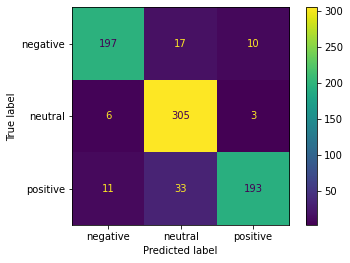

In [55]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=random_state)
rf_classifier.fit(X_train_tfidf, y_train_tfidf)
plot_confusion_matrix(rf_classifier, X_test_tfidf, y_test_tfidf)

### All classifiers on all text vertors

In [56]:
classsifiers = [
    LogisticRegression(random_state=random_state),
    SVC(gamma='auto'),
    KNeighborsClassifier(n_neighbors=50),
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(n_estimators=200, random_state=random_state),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=random_state)
]

In [57]:
vector_columns = [column for column in df.columns if column.startswith(("ohe", "wc", "tfidf"))]
df_scores = pd.DataFrame(index=vector_columns)
df_scores

""
ohe_tweet
ohe_tokenization
ohe_stemming
ohe_stemming+
ohe_lemmatization
ohe_misspealings
ohe_misspealings+lemma
ohe_filtered+tokenization
ohe_misspealings+lemma+filtered
wc_tweet


In [58]:
for classifier in classsifiers:
    list_scores = []
    for vectorized_text in vector_columns:
        X_train, X_test, y_train, y_test = train_test_split(df[vectorized_text].tolist(), df['tone'].tolist(), test_size=test_size, random_state=random_state, stratify=df['tone'])
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        list_scores.append(accuracy)
        print(f'classifier {classifier}, vectorized text "{vectorized_text}": accuracy is {accuracy}')
    df_scores[str(classifier)] = list_scores
    

classifier LogisticRegression(random_state=42), vectorized text "ohe_tweet": accuracy is 0.5303225806451612
classifier LogisticRegression(random_state=42), vectorized text "ohe_tokenization": accuracy is 0.5329032258064517
classifier LogisticRegression(random_state=42), vectorized text "ohe_stemming": accuracy is 0.5341935483870968
classifier LogisticRegression(random_state=42), vectorized text "ohe_stemming+": accuracy is 0.5341935483870968
classifier LogisticRegression(random_state=42), vectorized text "ohe_lemmatization": accuracy is 0.5341935483870968
classifier LogisticRegression(random_state=42), vectorized text "ohe_misspealings": accuracy is 0.5329032258064517
classifier LogisticRegression(random_state=42), vectorized text "ohe_misspealings+lemma": accuracy is 0.5341935483870968
classifier LogisticRegression(random_state=42), vectorized text "ohe_filtered+tokenization": accuracy is 0.5393548387096774
classifier LogisticRegression(random_state=42), vectorized text "ohe_misspeali

classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_stemming": accuracy is 0.8309677419354838
classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_stemming+": accuracy is 0.8232258064516129
classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_lemmatization": accuracy is 0.8309677419354838
classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_misspealings": accuracy is 0.8129032258064516
classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_misspealings+lemma": accuracy is 0.8129032258064516
classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_filtered+tokenization": accuracy is 0.6361290322580645
classifier KNeighborsClassifier(n_neighbors=50), vectorized text "tfidf_misspealings+lemma+filtered": accuracy is 0.5703225806451613
classifier DecisionTreeClassifier(random_state=42), vectorized text "ohe_tweet": accuracy is 0.5303225806451612
classifier DecisionTreeClassifier(rand

classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42), vectorized text "ohe_stemming+": accuracy is 0.4967741935483871
classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42), vectorized text "ohe_lemmatization": accuracy is 0.49548387096774194
classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42), vectorized text "ohe_misspealings": accuracy is 0.49548387096774194
classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42), vectorized text "ohe_misspealings+lemma": accuracy is 0.49290322580645163
classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42), vectorized text "ohe_filtered+tokenization": accuracy is 0.4993548387096774
classifier GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42), vectorized text "ohe_misspealings+lemma+filtered": accuracy is 0.5006451612903225
classifier GradientBoostingClassifier(l

In [59]:
df_scores

,LogisticRegression(random_state=42),SVC(gamma='auto'),KNeighborsClassifier(n_neighbors=50),DecisionTreeClassifier(random_state=42),"RandomForestClassifier(n_estimators=200, random_state=42)","GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=42)"
ohe_tweet,0.530323,0.405161,0.419355,0.530323,0.530323,0.495484
ohe_tokenization,0.532903,0.405161,0.419355,0.532903,0.532903,0.495484
ohe_stemming,0.534194,0.405161,0.419355,0.534194,0.534194,0.495484
ohe_stemming+,0.534194,0.405161,0.419355,0.534194,0.534194,0.496774
ohe_lemmatization,0.534194,0.405161,0.419355,0.534194,0.534194,0.495484
ohe_misspealings,0.532903,0.405161,0.419355,0.532903,0.532903,0.495484
ohe_misspealings+lemma,0.534194,0.405161,0.419355,0.534194,0.534194,0.492903
ohe_filtered+tokenization,0.539355,0.405161,0.424516,0.539355,0.539355,0.499355
ohe_misspealings+lemma+filtered,0.541935,0.405161,0.424516,0.541935,0.541935,0.500645
wc_tweet,0.900645,0.405161,0.609032,0.874839,0.892903,0.878710


### GridSearch

RandomForestClassifier(random_state=42)

In [83]:
vectors_gs = ['wc_tokenization', 'tfidf_tokenization']

In [97]:
n_estimators = [200, 300]
max_depth = [5, 8, None]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2] 
params = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)


for vectors in vectors_gs:
    X_train, X_test, y_train, y_test = train_test_split(df[vectors].tolist(), df['tone'].tolist(), test_size=test_size, random_state=random_state, stratify=df['tone'])
    rf = RandomForestClassifier(random_state=42)
    gridF = GridSearchCV(rf, params, cv = 3, verbose=1)
    bestF = gridF.fit(X_train, y_train)
    print(f'best params set is {bestF.best_params_}')
    best_predictions = bestF.predict(X_test)
    print(f'vectorized text "{vectors}", accuracy is {accuracy_score(y_test, best_predictions)}')

            

Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params set is {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
vectorized text "wc_tokenization", accuracy is 0.8916129032258064
Fitting 3 folds for each of 24 candidates, totalling 72 fits
best params set is {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
vectorized text "tfidf_tokenization", accuracy is 0.8980645161290323


LogisticRegression(random_state=42)

In [92]:
penalty = ['l2']
C = [0.1, 1, 10]

parameters = dict(penalty = penalty, C = C)

lr = LogisticRegression(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df['wc_tokenization'].tolist(), df['tone'].tolist(), test_size=test_size, random_state=random_state, stratify=df['tone'])

grid_search = GridSearchCV(estimator=lr, param_grid=parameters, scoring='accuracy', cv=3)
best_lr = grid_search.fit(X_train, y_train)
print(f'best params set is {best_lr.best_params_}')
best_predictions = best_lr.predict(X_test)
print(f'vectorized text "{vectorized_text}", accuracy is {accuracy_score(y_test, best_predictions)}')



best params set is {'C': 10, 'penalty': 'l2'}
vectorized text "tfidf_misspealings+lemma+filtered", accuracy is 0.9019354838709678


## LDA

In [98]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

/Users/marina.romashkova/.pyenv/versions/3.9.5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [99]:
pyLDAvis.enable_notebook()
vectors = CountVectorizer().fit_transform(df['filtered+tokenization'].astype('str'))

In [100]:
lda = LatentDirichletAllocation(n_components=3)
lda.fit(vectors)

LatentDirichletAllocation(n_components=3)

In [101]:
vectorizer = CountVectorizer().fit(df['filtered+tokenization'].astype('str'))
p3 = pyLDAvis.sklearn.prepare(lda, vectors, vectorizer)

/Users/marina.romashkova/.pyenv/versions/3.9.5/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/marina.romashkova/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/marina.romashkova/.pyenv/versions/3.9.5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/marina.romashkova/.pyenv/versions/3.9.5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is depre

In [102]:
p3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.108309  0.104259       1        1  39.711651
1     -0.055724 -0.129207       2        1  33.064962
2      0.164033  0.024948       3        1  27.223387, topic_info=        Term        Freq       Total Category  logprob  loglift
2553   happy  610.000000  610.000000  Default  30.0000  30.0000
2459   great  105.000000  105.000000  Default  29.0000  29.0000
2218  follow  100.000000  100.000000  Default  28.0000  28.0000
370     also   71.000000   71.000000  Default  27.0000  27.0000
4545  recent   77.000000   77.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
3321      ll   13.122423   40.747624   Topic3  -6.0592   0.1680
5103   since   10.713432   18.969981   Topic3  -6.2620   0.7297
1218      cm   10.784856   22.698036   Topic3  -6.2554   0.5570
3528    meet   10.391169   17.435401   Topic3  -6.2925   0.7835
2553   happy   10.131243  610.383049   Topic3  -6.3179  -2.7974

[181 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
370       2  0.988259         also
436       3  0.889797      anyways
467       1  0.675135  appreciated
467       2  0.322891  appreciated
483       2  0.964116         arms
...     ...       ...          ...
6269      2  0.903675         year
6269      3  0.090368         year
6270      3  0.889693        years
6280      3  0.889797           yg
6290      3  0.970492         york

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [103]:
pyLDAvis.save_html(p3, 'lda3.html')

Bonuses
- achieve a better accuracy on the test dataset – 0.851
- achieve an even better accuracy on the test dataset – 0.873
- use word2vec for vectorization of texts
- detailed classification_report
- more preprocessing ways (8 instead of 6)
- LDA
- some visualization